In [1]:
import pandas as pd 
from arguments import parser
from dataset import create_dataset
import os 
import utils 
import matplotlib.pyplot as plt 
import numpy as np 
import json 
import pandas as pd 
import torch 
import torch.nn.functional as F 
from glob import glob 
from models.model_retrieval import ALBEF
from models.tokenization_bert import BertTokenizer

np.random.seed = 42 

#### config #### 
default_setting = './configs/default.yaml'
task_setting = './configs/retrieval_coco.yaml'
config = parser(True, default_setting, task_setting)

config.args.distributed = False 

args = config.args 
args.result_dir = os.path.join(args.output_dir, 'result')


#### dataset ####
dataset = create_dataset('re', config) 
trainset = dataset[0]
from torch.utils.data import DataLoader
from dataset import re_collate_fn
train_loader = DataLoader(trainset,batch_size=16,shuffle=True, collate_fn= re_collate_fn)

device = 'cuda'
# tokenizer = BertTokenizer.from_pretrained(args.text_encoder)
# model = ALBEF(config=config, text_encoder=args.text_encoder, tokenizer=tokenizer, init_deit=True)
# model = model.to(device)   
# model_without_ddp = model

from augmentation import Romixgen
from torchvision import transforms 

romixgen = Romixgen(device = 'cuda',
                    batch_size = 16,
                    mix_ratio = config['romixgen']['mix_ratio'],
                    transform = transforms.Compose(trainset.transform.transforms[1:])
                    )
self = romixgen 

# from models.factory import load_model_retrieval
# device = 'cuda'
# model, model_without_ddp, tokenizer = load_model_retrieval(args, config, device)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:804: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [59]:
from PIL import Image 

for image, text, idx in train_loader:
    image,text = romixgen(image, text)
    image = torch.stack([romixgen.transform(Image.fromarray(x.astype(np.uint8))) for x in image])
    break 

In [13]:
transforms.Compose(trainset.transform.transforms[1:])

Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

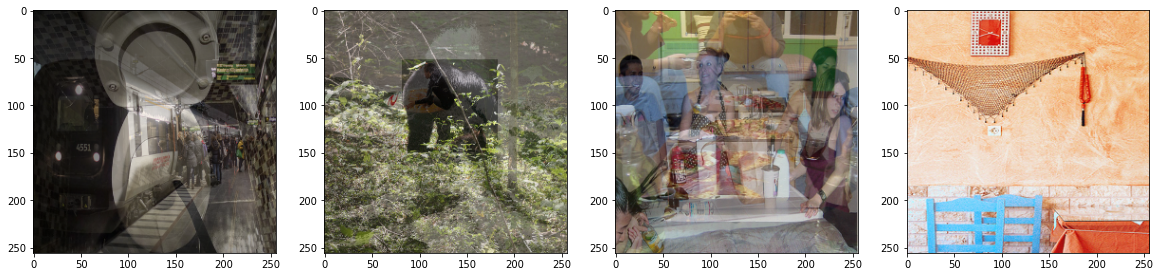

In [6]:

fig, ax = plt.subplots(1,4 ,figsize=(20,15))

for i in range(len(ax)):
    ax[i].imshow(new_image[i].astype(np.int))

In [64]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

label_objs = text[:4]
label_bgs = text[8:12]
task_prefix = ' Generate sentence including horse :'
inputs = [task_prefix + a + " " + b for a, b in zip(label_objs, label_bgs)]
inputs = tokenizer(inputs, return_tensors='pt',padding=True)

output_sequences = model.generate(
    input_ids = inputs['input_ids'],
    max_length = 30
    # temperature = 0.5,
    # top_p = 0.8,
    # do_sample = True
)
outputs = tokenizer.batch_decode(output_sequences, skip_special_tokens=True)